In [105]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
import numpy as np
import time
import subprocess, sys, os
import copy
import optuna.integration.lightgbm as LGB_optuna
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# data preprocessing

#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg38/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg38.fa; done')
#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg19.fa; done')

#pd.set_option('display.max_columns', 30)
#pd.set_option('display.max_rows', 30)

df = pd.read_excel("/mnt/HDD8TB/MicroSEC/source/MANOSEC_source.xlsx")

sort_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
              'chr21', 'chr22', 'chrX', 'chrY']
df.Chr = pd.Categorical(df.Chr, categories = sort_order)
df.sort_values(by=['Chr'], inplace=True)
df = df.reset_index()
df['palindrome'] = ""
df['search_seq_A'] = ""
df['search_seq_B'] = ""
df['search_seq_C'] = ""
df['search_seq_D'] = ""
df['rev_comp_seq'] = 0
df['search_hairpin_A'] = ""
df['search_hairpin_B'] = ""
df['search_hairpin_C'] = ""
df['search_hairpin_D'] = ""
df['search_hairpin_E'] = ""
df['possible_hairpin_A_1'] = 0
df['possible_hairpin_A_2'] = 0
df['possible_hairpin_A_3'] = 0
df['possible_hairpin_A_4'] = 0
df['possible_hairpin_A_5'] = 0
df['possible_hairpin_A_6'] = 0
df['possible_hairpin_B_1'] = 0
df['possible_hairpin_B_2'] = 0
df['possible_hairpin_B_3'] = 0
df['possible_hairpin_B_4'] = 0
df['possible_hairpin_B_5'] = 0
df['possible_hairpin_B_6'] = 0
df['possible_hairpin_C_1'] = 0
df['possible_hairpin_C_2'] = 0
df['possible_hairpin_C_3'] = 0
df['possible_hairpin_C_4'] = 0
df['possible_hairpin_C_5'] = 0
df['possible_hairpin_C_6'] = 0
df['possible_hairpin_D_1'] = 0
df['possible_hairpin_D_2'] = 0
df['possible_hairpin_D_3'] = 0
df['possible_hairpin_D_4'] = 0
df['possible_hairpin_D_5'] = 0
df['possible_hairpin_D_6'] = 0
df['possible_hairpin_E_1'] = 0
df['possible_hairpin_E_2'] = 0
df['possible_hairpin_E_3'] = 0
df['possible_hairpin_E_4'] = 0
df['possible_hairpin_E_5'] = 0
df['possible_hairpin_E_6'] = 0
df['score_A_20'] = 0
df['score_A_25'] = 0
df['score_A_30'] = 0
df['score_A_35'] = 0
df['score_A_40'] = 0
df['score_A_45'] = 0
df['score_A_50'] = 0
df['score_A_55'] = 0
df['score_A_60'] = 0
df['score_B_20'] = 0
df['score_B_25'] = 0
df['score_B_30'] = 0
df['score_B_35'] = 0
df['score_B_40'] = 0
df['score_B_45'] = 0
df['score_B_50'] = 0
df['score_B_55'] = 0
df['score_B_60'] = 0
df['score_C_20'] = 0
df['score_C_25'] = 0
df['score_C_30'] = 0
df['score_C_35'] = 0
df['score_C_40'] = 0
df['score_C_45'] = 0
df['score_C_50'] = 0
df['score_C_55'] = 0
df['score_C_60'] = 0
df['score_D_20'] = 0
df['score_D_25'] = 0
df['score_D_30'] = 0
df['score_D_35'] = 0
df['score_D_40'] = 0
df['score_D_45'] = 0
df['score_D_50'] = 0
df['score_D_55'] = 0
df['score_D_60'] = 0
df_working = copy.deepcopy(df)
filename_BLAT = "/mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT.fa"
f = open(filename_BLAT, 'w', encoding='UTF-8')
records = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg38.fa', 'fasta')
j = 0
for record in records:
    if df_working.shape[0] > 0:
        if record.name == df_working.iloc[0].Chr:
            df_tmp = df_working[df_working['Chr'] == df_working.iloc[0].Chr]
            df_working = df_working[df_working['Chr'] != df_working.iloc[0].Chr]
            for i in range(df_tmp.shape[0]):
                if (j + 1) % 500 == 0:
                    print(str(j + 1) + " / " + str(df.shape[0]))
                ID = str(j)
                pos_start_1 = df_tmp.iloc[i].Pos - 31
                pos_start_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) - 1
                pos_end_1 = df_tmp.iloc[i].Pos - 1
                pos_end_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) + 29
                seq_tmp = (str(record.seq[pos_start_1:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_end_2])).lower()
                f.write('>' + ID + '\n')
                f.write(seq_tmp + '\n')
                df.loc[j, 'palindrome'] = (str(record.seq[pos_end_1 - 200:pos_end_1]) + df_tmp.iloc[i].Ref + str(record.seq[pos_start_2:pos_start_2 + 200])).lower()
                df.loc[j, 'search_seq_A'] = (str(record.seq[pos_end_1 - 3:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 3])).upper()
                df.loc[j, 'search_seq_B'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df.loc[j, 'search_seq_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_tmp.iloc[i].Alt).upper()
                df.loc[j, 'search_seq_D'] = (df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                if str(Seq(df_tmp.iloc[i].Alt).reverse_complement()).upper() == df_tmp.iloc[i].Ref.upper():
                    df.loc[j, 'rev_comp_seq'] = 1
                df.loc[j, 'search_hairpin_A'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df.loc[j, 'search_hairpin_B'] = (str(record.seq[pos_end_1 - 6:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 6])).upper()
                df.loc[j, 'search_hairpin_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                df.loc[j, 'search_hairpin_D'] = (str(record.seq[pos_end_1 - 10:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 10])).upper()
                df.loc[j, 'search_hairpin_E'] = (str(record.seq[pos_end_1 - 12:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 12])).upper()
                j = j + 1
print(str(j) + " / " + str(df.shape[0]))
f.close()
os.system('blat -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 /mnt/HDD8TB/MicroSEC/source/hg38.fa /mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT.fa /mnt/HDD8TB/MicroSEC/source/output.pslx -out=pslx -t=dna -q=dna')
os.system('sed "1,5d" /mnt/HDD8TB/MicroSEC/source/output.pslx > /mnt/HDD8TB/MicroSEC/source/output.tsv')

result_BLAT = pd.read_csv('/mnt/HDD8TB/MicroSEC/source/output.tsv', delimiter='\t', header=None)

for i in range(df.shape[0]):
    if (i + 1) % 500 == 0:
        print(str(i + 1) + " / " + str(df.shape[0]))
    df.loc[i, 'possible_hairpin_A_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_A'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_A_20'] = df.loc[i, 'score_A_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_A_25'] = df.loc[i, 'score_A_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_A_30'] = df.loc[i, 'score_A_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_A_35'] = df.loc[i, 'score_A_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_A_40'] = df.loc[i, 'score_A_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_A_45'] = df.loc[i, 'score_A_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_A_50'] = df.loc[i, 'score_A_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_A_55'] = df.loc[i, 'score_A_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_A_60'] = df.loc[i, 'score_A_60'] + 1
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_B'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_B_20'] = df.loc[i, 'score_B_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_B_25'] = df.loc[i, 'score_B_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_B_30'] = df.loc[i, 'score_B_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_B_35'] = df.loc[i, 'score_B_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_B_40'] = df.loc[i, 'score_B_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_B_45'] = df.loc[i, 'score_B_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_B_50'] = df.loc[i, 'score_B_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_B_55'] = df.loc[i, 'score_B_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_B_60'] = df.loc[i, 'score_B_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_C'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_C_20'] = df.loc[i, 'score_C_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_C_25'] = df.loc[i, 'score_C_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_C_30'] = df.loc[i, 'score_C_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_C_35'] = df.loc[i, 'score_C_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_C_40'] = df.loc[i, 'score_C_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_C_45'] = df.loc[i, 'score_C_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_C_50'] = df.loc[i, 'score_C_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_C_55'] = df.loc[i, 'score_C_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_C_60'] = df.loc[i, 'score_C_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_D'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_D_20'] = df.loc[i, 'score_D_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_D_25'] = df.loc[i, 'score_D_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_D_30'] = df.loc[i, 'score_D_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_D_35'] = df.loc[i, 'score_D_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_D_40'] = df.loc[i, 'score_D_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_D_45'] = df.loc[i, 'score_D_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_D_50'] = df.loc[i, 'score_D_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_D_55'] = df.loc[i, 'score_D_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_D_60'] = df.loc[i, 'score_D_60'] + 1

print(str(i + 1) + " / " + str(df.shape[0]))

df.to_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed.xlsx')

X = df.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_A_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]
X["SNV"] = df.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X["DEL"] = df.loc[:, ("Mut_type")].str.contains("del").astype(int)
X["INS"] = df.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X["bases"] = df.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)

y = (df.loc[:, "msec_filter_1234"]).astype(int)


###########################################

df_MSK = pd.read_excel("/mnt/HDD8TB/MicroSEC/source/mutation_MSK.xlsx")

sort_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
              'chr21', 'chr22', 'chrX', 'chrY']
df_MSK.Chr = pd.Categorical(df_MSK.Chr, categories = sort_order)
df_MSK.sort_values(by=['Chr'], inplace=True)
df_MSK = df_MSK.reset_index()
df_MSK['palindrome'] = ""
df_MSK['search_seq_A'] = ""
df_MSK['search_seq_B'] = ""
df_MSK['search_seq_C'] = ""
df_MSK['search_seq_D'] = ""
df_MSK['rev_comp_seq'] = 0
df_MSK['search_hairpin_A'] = ""
df_MSK['search_hairpin_B'] = ""
df_MSK['search_hairpin_C'] = ""
df_MSK['search_hairpin_D'] = ""
df_MSK['search_hairpin_E'] = ""
df_MSK['possible_hairpin_A_1'] = 0
df_MSK['possible_hairpin_A_2'] = 0
df_MSK['possible_hairpin_A_3'] = 0
df_MSK['possible_hairpin_A_4'] = 0
df_MSK['possible_hairpin_A_5'] = 0
df_MSK['possible_hairpin_A_6'] = 0
df_MSK['possible_hairpin_B_1'] = 0
df_MSK['possible_hairpin_B_2'] = 0
df_MSK['possible_hairpin_B_3'] = 0
df_MSK['possible_hairpin_B_4'] = 0
df_MSK['possible_hairpin_B_5'] = 0
df_MSK['possible_hairpin_B_6'] = 0
df_MSK['possible_hairpin_C_1'] = 0
df_MSK['possible_hairpin_C_2'] = 0
df_MSK['possible_hairpin_C_3'] = 0
df_MSK['possible_hairpin_C_4'] = 0
df_MSK['possible_hairpin_C_5'] = 0
df_MSK['possible_hairpin_C_6'] = 0
df_MSK['possible_hairpin_D_1'] = 0
df_MSK['possible_hairpin_D_2'] = 0
df_MSK['possible_hairpin_D_3'] = 0
df_MSK['possible_hairpin_D_4'] = 0
df_MSK['possible_hairpin_D_5'] = 0
df_MSK['possible_hairpin_D_6'] = 0
df_MSK['possible_hairpin_E_1'] = 0
df_MSK['possible_hairpin_E_2'] = 0
df_MSK['possible_hairpin_E_3'] = 0
df_MSK['possible_hairpin_E_4'] = 0
df_MSK['possible_hairpin_E_5'] = 0
df_MSK['possible_hairpin_E_6'] = 0
df_MSK['score_A_20'] = 0
df_MSK['score_A_25'] = 0
df_MSK['score_A_30'] = 0
df_MSK['score_A_35'] = 0
df_MSK['score_A_40'] = 0
df_MSK['score_A_45'] = 0
df_MSK['score_A_50'] = 0
df_MSK['score_A_55'] = 0
df_MSK['score_A_60'] = 0
df_MSK['score_B_20'] = 0
df_MSK['score_B_25'] = 0
df_MSK['score_B_30'] = 0
df_MSK['score_B_35'] = 0
df_MSK['score_B_40'] = 0
df_MSK['score_B_45'] = 0
df_MSK['score_B_50'] = 0
df_MSK['score_B_55'] = 0
df_MSK['score_B_60'] = 0
df_MSK['score_C_20'] = 0
df_MSK['score_C_25'] = 0
df_MSK['score_C_30'] = 0
df_MSK['score_C_35'] = 0
df_MSK['score_C_40'] = 0
df_MSK['score_C_45'] = 0
df_MSK['score_C_50'] = 0
df_MSK['score_C_55'] = 0
df_MSK['score_C_60'] = 0
df_MSK['score_D_20'] = 0
df_MSK['score_D_25'] = 0
df_MSK['score_D_30'] = 0
df_MSK['score_D_35'] = 0
df_MSK['score_D_40'] = 0
df_MSK['score_D_45'] = 0
df_MSK['score_D_50'] = 0
df_MSK['score_D_55'] = 0
df_MSK['score_D_60'] = 0

df_MSK_working = copy.deepcopy(df_MSK)
filename_BLAT = "/mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_MSK.fa"
f = open(filename_BLAT, 'w', encoding='UTF-8')
records_MSK = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg19.fa', 'fasta')
j = 0
for record in records_MSK:
    if df_MSK_working.shape[0] > 0:
        if record.name == df_MSK_working.iloc[0].Chr:
            df_MSK_tmp = df_MSK_working[df_MSK_working['Chr'] == df_MSK_working.iloc[0].Chr]
            df_MSK_working = df_MSK_working[df_MSK_working['Chr'] != df_MSK_working.iloc[0].Chr]
            for i in range(df_MSK_tmp.shape[0]):
                if (j + 1) % 500 == 0:
                    print(str(j + 1) + " / " + str(df_MSK.shape[0]))
                ID = str(j)
                pos_start_1 = df_MSK_tmp.iloc[i].Pos - 31
                pos_start_2 = df_MSK_tmp.iloc[i].Pos + len(df_MSK_tmp.iloc[i].Ref) - 1
                pos_end_1 = df_MSK_tmp.iloc[i].Pos - 1
                pos_end_2 = df_MSK_tmp.iloc[i].Pos + len(df_MSK_tmp.iloc[i].Ref) + 29
                seq_tmp = (str(record.seq[pos_start_1:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_end_2])).lower()
                f.write('>' + ID + '\n')
                f.write(seq_tmp + '\n')
                df_MSK.loc[j, 'palindrome'] = (str(record.seq[pos_end_1 - 200:pos_end_1]) + df_MSK_tmp.iloc[i].Ref + str(record.seq[pos_start_2:pos_start_2 + 200])).lower()
                df_MSK.loc[j, 'search_seq_A'] = (str(record.seq[pos_end_1 - 3:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 3])).upper()
                df_MSK.loc[j, 'search_seq_B'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df_MSK.loc[j, 'search_seq_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_MSK_tmp.iloc[i].Alt).upper()
                df_MSK.loc[j, 'search_seq_D'] = (df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                if str(Seq(df_MSK_tmp.iloc[i].Alt).reverse_complement()).upper() == df_MSK_tmp.iloc[i].Ref.upper():
                    df_MSK.loc[j, 'rev_comp_seq'] = 1
                df_MSK.loc[j, 'search_hairpin_A'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df_MSK.loc[j, 'search_hairpin_B'] = (str(record.seq[pos_end_1 - 6:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 6])).upper()
                df_MSK.loc[j, 'search_hairpin_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                df_MSK.loc[j, 'search_hairpin_D'] = (str(record.seq[pos_end_1 - 10:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 10])).upper()
                df_MSK.loc[j, 'search_hairpin_E'] = (str(record.seq[pos_end_1 - 12:pos_end_1]) + df_MSK_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 12])).upper()

                j = j + 1
print(str(j) + " / " + str(df_MSK.shape[0]))
f.close()
os.system('blat -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 /mnt/HDD8TB/MicroSEC/source/hg19.fa /mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_MSK.fa /mnt/HDD8TB/MicroSEC/source/output_MSK.pslx -out=pslx -t=dna -q=dna')
os.system('sed "1,5d" /mnt/HDD8TB/MicroSEC/source/output_MSK.pslx > /mnt/HDD8TB/MicroSEC/source/output_MSK.tsv')

result_BLAT_MSK = pd.read_csv('/mnt/HDD8TB/MicroSEC/source/output_MSK.tsv', delimiter='\t', header=None)

for i in range(df_MSK.shape[0]):
    if (i + 1) % 500 == 0:
        print(str(i + 1) + " / " + str(df_MSK.shape[0]))
    df_MSK.loc[i, 'possible_hairpin_A_1'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_A_2'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_A_3'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_A_4'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_A_5'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_A_6'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_1'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_2'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_3'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_4'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_5'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_B_6'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_1'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_2'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_3'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_4'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_5'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_C_6'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_1'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_2'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_3'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_4'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_5'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_D_6'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_1'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_2'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_3'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_4'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_5'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_MSK.loc[i, 'possible_hairpin_E_6'] = pairwise2.align.localms(df_MSK.loc[i,'palindrome'], str(Seq(df_MSK.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_MSK.loc[i, 'search_seq_A'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_MSK.loc[i, 'score_A_20'] = df_MSK.loc[i, 'score_A_20'] + 1
            if tmp_score >= 25:
                df_MSK.loc[i, 'score_A_25'] = df_MSK.loc[i, 'score_A_25'] + 1
            if tmp_score >= 30:
                df_MSK.loc[i, 'score_A_30'] = df_MSK.loc[i, 'score_A_30'] + 1
            if tmp_score >= 35:
                df_MSK.loc[i, 'score_A_35'] = df_MSK.loc[i, 'score_A_35'] + 1
            if tmp_score >= 40:
                df_MSK.loc[i, 'score_A_40'] = df_MSK.loc[i, 'score_A_40'] + 1
            if tmp_score >= 45:
                df_MSK.loc[i, 'score_A_45'] = df_MSK.loc[i, 'score_A_45'] + 1
            if tmp_score >= 50:
                df_MSK.loc[i, 'score_A_50'] = df_MSK.loc[i, 'score_A_50'] + 1
            if tmp_score >= 55:
                df_MSK.loc[i, 'score_A_55'] = df_MSK.loc[i, 'score_A_55'] + 1
            if tmp_score >= 60:
                df_MSK.loc[i, 'score_A_60'] = df_MSK.loc[i, 'score_A_60'] + 1
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_MSK.loc[i, 'search_seq_B'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_MSK.loc[i, 'score_B_20'] = df_MSK.loc[i, 'score_B_20'] + 1
            if tmp_score >= 25:
                df_MSK.loc[i, 'score_B_25'] = df_MSK.loc[i, 'score_B_25'] + 1
            if tmp_score >= 30:
                df_MSK.loc[i, 'score_B_30'] = df_MSK.loc[i, 'score_B_30'] + 1
            if tmp_score >= 35:
                df_MSK.loc[i, 'score_B_35'] = df_MSK.loc[i, 'score_B_35'] + 1
            if tmp_score >= 40:
                df_MSK.loc[i, 'score_B_40'] = df_MSK.loc[i, 'score_B_40'] + 1
            if tmp_score >= 45:
                df_MSK.loc[i, 'score_B_45'] = df_MSK.loc[i, 'score_B_45'] + 1
            if tmp_score >= 50:
                df_MSK.loc[i, 'score_B_50'] = df_MSK.loc[i, 'score_B_50'] + 1
            if tmp_score >= 55:
                df_MSK.loc[i, 'score_B_55'] = df_MSK.loc[i, 'score_B_55'] + 1
            if tmp_score >= 60:
                df_MSK.loc[i, 'score_B_60'] = df_MSK.loc[i, 'score_B_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_MSK.loc[i, 'search_seq_C'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_MSK.loc[i, 'score_C_20'] = df_MSK.loc[i, 'score_C_20'] + 1
            if tmp_score >= 25:
                df_MSK.loc[i, 'score_C_25'] = df_MSK.loc[i, 'score_C_25'] + 1
            if tmp_score >= 30:
                df_MSK.loc[i, 'score_C_30'] = df_MSK.loc[i, 'score_C_30'] + 1
            if tmp_score >= 35:
                df_MSK.loc[i, 'score_C_35'] = df_MSK.loc[i, 'score_C_35'] + 1
            if tmp_score >= 40:
                df_MSK.loc[i, 'score_C_40'] = df_MSK.loc[i, 'score_C_40'] + 1
            if tmp_score >= 45:
                df_MSK.loc[i, 'score_C_45'] = df_MSK.loc[i, 'score_C_45'] + 1
            if tmp_score >= 50:
                df_MSK.loc[i, 'score_C_50'] = df_MSK.loc[i, 'score_C_50'] + 1
            if tmp_score >= 55:
                df_MSK.loc[i, 'score_C_55'] = df_MSK.loc[i, 'score_C_55'] + 1
            if tmp_score >= 60:
                df_MSK.loc[i, 'score_C_60'] = df_MSK.loc[i, 'score_C_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_MSK.loc[i, 'search_seq_D'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_MSK.loc[i, 'score_D_20'] = df_MSK.loc[i, 'score_D_20'] + 1
            if tmp_score >= 25:
                df_MSK.loc[i, 'score_D_25'] = df_MSK.loc[i, 'score_D_25'] + 1
            if tmp_score >= 30:
                df_MSK.loc[i, 'score_D_30'] = df_MSK.loc[i, 'score_D_30'] + 1
            if tmp_score >= 35:
                df_MSK.loc[i, 'score_D_35'] = df_MSK.loc[i, 'score_D_35'] + 1
            if tmp_score >= 40:
                df_MSK.loc[i, 'score_D_40'] = df_MSK.loc[i, 'score_D_40'] + 1
            if tmp_score >= 45:
                df_MSK.loc[i, 'score_D_45'] = df_MSK.loc[i, 'score_D_45'] + 1
            if tmp_score >= 50:
                df_MSK.loc[i, 'score_D_50'] = df_MSK.loc[i, 'score_D_50'] + 1
            if tmp_score >= 55:
                df_MSK.loc[i, 'score_D_55'] = df_MSK.loc[i, 'score_D_55'] + 1
            if tmp_score >= 60:
                df_MSK.loc[i, 'score_D_60'] = df_MSK.loc[i, 'score_D_60'] + 1

print(str(i + 1) + " / " + str(df_MSK.shape[0]))

df_MSK.to_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed_MSK.xlsx')

X_MSK = df_MSK.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_A_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]

X_MSK["SNV"] = df_MSK.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X_MSK["DEL"] = df_MSK.loc[:, ("Mut_type")].str.contains("del").astype(int)
X_MSK["INS"] = df_MSK.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X_MSK["bases"] = df_MSK.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)



In [47]:
df = pd.read_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed.xlsx')

X = df.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_B_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]
X["SNV"] = df.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X["DEL"] = df.loc[:, ("Mut_type")].str.contains("del").astype(int)
X["INS"] = df.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X["bases"] = df.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)

y = (df.loc[:, "msec_filter_1234"]).astype(int)


df_MSK = pd.read_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed_MSK.xlsx')

X_MSK = df_MSK.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_B_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]

X_MSK["SNV"] = df_MSK.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X_MSK["DEL"] = df_MSK.loc[:, ("Mut_type")].str.contains("del").astype(int)
X_MSK["INS"] = df_MSK.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X_MSK["bases"] = df_MSK.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)


RandomForestClassifier(max_depth=25, max_features=10, min_samples_split=10,
                       n_estimators=20, random_state=2525)
acc: 0.9578872234118487
AUC curve : 0.985787


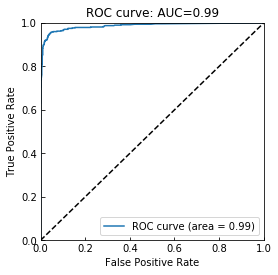

RandomForestClassifier(max_depth=20, max_features=18, min_samples_split=5,
                       n_estimators=30, random_state=2525)
acc: 0.9621698786581013
AUC curve : 0.987511


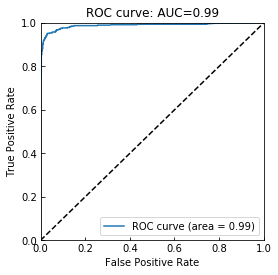

RandomForestClassifier(max_depth=25, max_features=18, min_samples_split=3,
                       n_estimators=20, random_state=2525)
acc: 0.9650249821556032
AUC curve : 0.986591


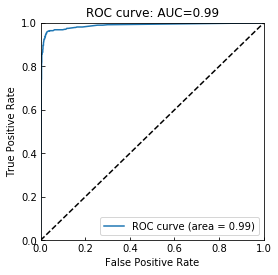

RandomForestClassifier(max_depth=25, max_features=14, min_samples_split=10,
                       n_estimators=30, random_state=2525)
acc: 0.9678800856531049
AUC curve : 0.990770


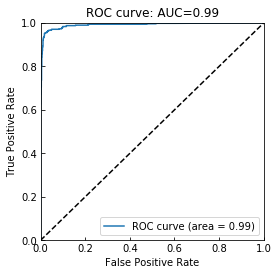

RandomForestClassifier(max_depth=25, max_features=6, min_samples_split=5,
                       n_estimators=30, random_state=2525)
acc: 0.9607142857142857
AUC curve : 0.988032


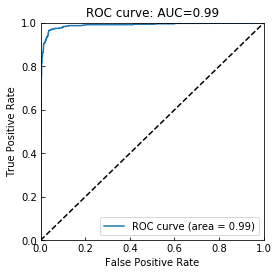

AUC curve : 0.987756


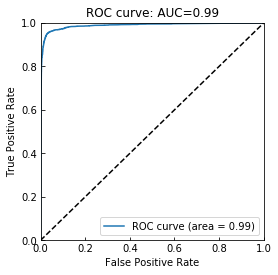

,MicroSEC mutation,MicroSEC artifact
predicted_25 mutation,4383,86
predicted_25 artifact,255,2280
predicted_50 mutation,4539,161
predicted_50 artifact,99,2205
predicted_75 mutation,4591,288
predicted_75 artifact,47,2078
predicted_90 mutation,4619,469
predicted_90 artifact,19,1897
predicted_95 mutation,4624,603
predicted_95 artifact,14,1763


In [141]:
X_RF = np.array(X)
y_RF = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_total = []
y_proba_total = []
y_true = []
for train, test in skf.split(X_RF, y_RF):
    X_train = X_RF[train]
    X_test = X_RF[test]
    y_train = y_RF[train]
    y_test = y_RF[test]
    #X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, shuffle=True, test_size=0.25, stratify=y_tv, random_state=100)

    search_params = {
        'n_estimators'      : [10, 15, 20, 30],
        'max_features'      : [6, 8, 10, 14, 18],
        'random_state'      : [2525],
        'min_samples_split' : [2, 3, 5, 10],
        'max_depth'         : [20, 25, 30]
    }


    gs = GridSearchCV(RFC(),
                      search_params,
                      cv=4,
                      verbose=False,
                      n_jobs=-1)
    gs.fit(X_train, y_train)

    print(gs.best_estimator_)
    print(f"acc: {gs.score(X_test, y_test)}")
    y_pred = gs.predict(X_test)
    y_proba = gs.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total = np.concatenate([y_pred_total, y_pred])
    y_proba_total = np.concatenate([y_proba_total, y_proba[:, 1]])
    y_true = np.concatenate([y_true, y_test])

fpr, tpr, thresholds = roc_curve(y_true, y_proba_total)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_25 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total)
for i in range(len(y_proba_total)):
    if y_proba_total[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0



# 予測結果と、正解（本当の答え）がどのくらい合っていたかを表す混同行列
conf_matrix = confusion_matrix(y_pred_temp_25, y_true)
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_50, y_true)])
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_75, y_true)])
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_90, y_true)])
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_95, y_true)])
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_975, y_true)])
conf_matrix = np.concatenate([conf_matrix, confusion_matrix(y_pred_temp_99, y_true)])

pd.DataFrame(conf_matrix, index=['predicted_25 mutation', 'predicted_25 artifact', 
                                 'predicted_50 mutation', 'predicted_50 artifact',
                                 'predicted_75 mutation', 'predicted_75 artifact',
                                 'predicted_90 mutation', 'predicted_90 artifact',
                                 'predicted_95 mutation', 'predicted_95 artifact',
                                 'predicted_97.5 mutation', 'predicted_97.5 artifact',
                                 'predicted_99 mutation', 'predicted_99 artifact'],
                          columns=['MicroSEC mutation', 'MicroSEC artifact'])


In [135]:
gs = GridSearchCV(RFC(),
                  search_params,
                  cv=4,
                  verbose=False,
                  n_jobs=-1)
gs.fit(X_RF, y_RF)

print(gs.best_estimator_)

y_MSK_proba = gs.predict_proba(X_MSK)[:,1]
df_MSK[y_MSK_proba>0.95]

RandomForestClassifier(max_depth=30, max_features=10, min_samples_split=10,
                       n_estimators=30, random_state=2525)


,Unnamed: 0,index,t_ref_count,t_alt_count,Chr,Sample,%Alt,Gene,HGVS.p,Pos,...,score_C_60,score_D_20,score_D_25,score_D_30,score_D_35,score_D_40,score_D_45,score_D_50,score_D_55,score_D_60
2951,2951,1130,526,40,chr1,X,7.067138,ARID1A,p.V161A,27023376,...,0,0,0,0,0,0,0,0,0,0
8555,8555,41036,705,43,chr2,X,5.748663,CUL3,p.R153H,225379410,...,0,0,0,0,0,0,0,0,0,0
20275,20275,61971,85,10,chr5,X,10.526316,TERT,p.A242T,1294277,...,0,0,0,0,0,0,0,0,0,0
25653,25653,62844,144,10,chr6,X,6.493506,ARID1B,p.S451P,157100414,...,0,0,0,0,0,0,0,0,0,0
28173,28173,62685,272,29,chr6,X,9.634551,ARID1B,p.G314R,157100003,...,0,0,0,0,0,0,0,0,0,0
30782,30782,68852,1297,69,chr7,X,5.051245,MET,p.T698F,116397818,...,0,0,0,0,0,0,0,0,0,0
32883,32883,71097,203,19,chr8,X,8.558559,SOX17,p.G200C,55371908,...,0,0,0,0,0,0,0,0,0,0
33744,33744,72579,365,29,chr9,X,7.360406,NOTCH1,p.E424K,139412375,...,0,0,0,0,0,0,0,0,0,0
35912,35912,74305,941,136,chr9,X,12.627669,TGFBR1,p.S235F,101900270,...,0,0,0,0,0,0,0,0,0,0
38868,38868,6769,895,52,chr10,X,5.491024,RET,p.R959W,43619192,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


504


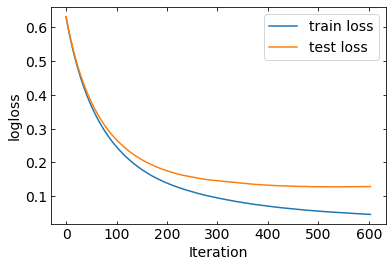

AUC curve : 0.985792


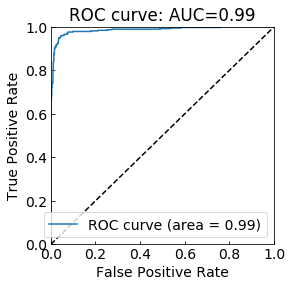

,real 0,real 1
predicted 0,718,29
predicted 1,24,350


In [94]:
l = LabelEncoder() 
l.fit(y)
Y = pd.Series(l.transform(y)) 

X_tv, test_x, Y_tv, test_y = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=100)
train_x, val_x, train_y, val_y = train_test_split(X_tv, Y_tv, shuffle=True, test_size=0.2, stratify=Y_tv, random_state=100)

trains = lgb.Dataset(train_x.values, train_y.values, free_raw_data=False)
valids = lgb.Dataset(val_x.values, val_y.values, free_raw_data=False)
tvs = lgb.Dataset(X_tv.values, Y_tv.values, free_raw_data=False)
tests = lgb.Dataset(test_x.values, test_y.values, free_raw_data=False)
#パラメータ設定
param = {'objective':'binary',
         'max_depth':16,
         'learning_rate':0.01,
         'max_bin':512,
         'metric':['auc', 'binary_logloss'],
         'num_iteration':2000,
         'verbosity': -1}

#学習
start=time.time()
best = LGB_optuna.train(param,
                        train_set=trains,
                        valid_sets=[trains, valids],
                        valid_names=['Train', 'Test'],
                        num_boost_round=4000,
                        verbose_eval=False,
                        early_stopping_rounds=100)
stop=time.time()

execution_time_lgb = stop-start
execution_time_lgb

lgb_results = {}

model = lgb.train(param,
                        train_set=trains,
                        valid_sets=[trains, valids],
                        valid_names=['Train', 'Test'],
                        num_boost_round=4000,
                        verbose_eval=False,
                        early_stopping_rounds=100,
                        evals_result=lgb_results)
loss_train = lgb_results['Train']['binary_logloss']  # 訓練誤差
loss_test = lgb_results['Test']['binary_logloss']    # 汎化誤差
best_iteration = model.best_iteration               # 最良の予測器が得られたイタレーション数
print(best_iteration)
# フォントの種類とサイズを設定する。
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'
 
# 目盛を内側にする。
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
#  グラフの入れ物を用意する。
fig = plt.figure()
ax1 = fig.add_subplot(111)
 
# グラフの上下左右に目盛線を付ける。
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
 
# 軸のラベルを設定する。
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
# データプロットする。
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
# グラフを表示する。
plt.legend()
plt.show()
plt.close()

ypred2=model.predict(val_x)
# AUCスコアを出す
fpr, tpr, thresholds = roc_curve(val_y, ypred2)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)

# ROC curve を描く
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()



for i in range(len(ypred2)):
    if ypred2[i]>=.5: # setting threshold to .5
        ypred2[i]=1
    else: 
        ypred2[i]=0

# 予測結果と、正解（本当の答え）がどのくらい合っていたかを表す混同行列
pd.DataFrame(confusion_matrix(ypred2, val_y), 
             index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])




[2696  101  209  348  279  113   44  165  295  337  199  168  123  781
  224  457  184  123   87  516  263  348  367  255  168  190  612  319
  515  145  210  278  189    0    0   12  139   90  121  133  198  158
    0    0   13   71   38   73   22   10  456    0    0  180  217  126
  210  118   68   47    0    0    0   50  136  153   60  422  285   70
   10  126]


,importance
%Alt,2696
possible_hairpin_B_6,781
possible_hairpin_E_1,612
possible_hairpin_C_6,516
possible_hairpin_E_3,515
...,...
score_B_25,0
score_C_30,0
score_C_25,0
score_A_30,0


importance    15120
dtype: int64

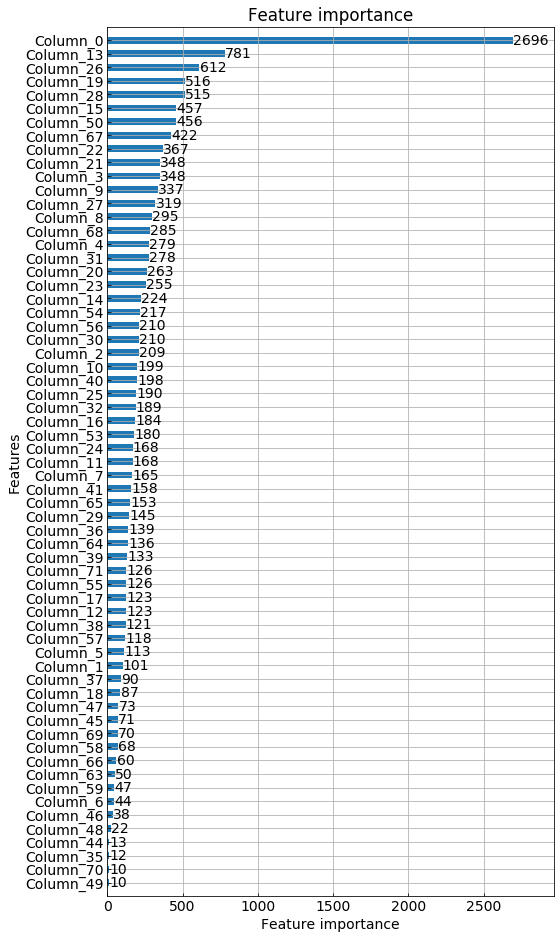

In [103]:
print(model.feature_importance())
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

importance = pd.DataFrame(model.feature_importance(), index = X.columns, columns=["importance"])
display(importance.sort_values("importance", ascending= False))
importance.sum()

In [82]:
y_proba = model.predict(X_MSK)
df_MSK[y_proba>0.5]

,Unnamed: 0,index,t_ref_count,t_alt_count,Chr,Sample,%Alt,Gene,HGVS.p,Pos,...,score_C_60,score_D_20,score_D_25,score_D_30,score_D_35,score_D_40,score_D_45,score_D_50,score_D_55,score_D_60
189,189,3289,456,24,chr1,X,5.000000,NOTCH2,p.A1916T,120461970,...,0,0,0,0,0,0,0,0,0,0
443,443,3798,370,20,chr1,X,5.128205,NTRK1,p.V715M,156849887,...,0,0,0,0,0,0,0,0,0,0
843,843,2615,506,42,chr1,X,7.664234,MPL,p.S3P,43803526,...,0,0,0,0,0,0,0,0,0,0
849,849,2588,508,31,chr1,X,5.751391,MPL,p.N250I,43805693,...,0,0,0,0,0,0,0,0,0,0
1067,1067,3215,794,50,chr1,X,5.924171,NOTCH2,p.G1347A,120468399,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77725,77725,76203,1137,110,chrX,X,8.821171,BTK,p.P265S,100615122,...,0,0,0,0,0,0,0,0,0,0
77830,77830,75647,257,493,chrX,X,65.733333,ATRX,p.R1302Kfs*7,76920172,...,0,0,0,0,0,0,0,0,0,0
77842,77842,75629,490,47,chrX,X,8.752328,ATRX,p.H544D,76939118,...,0,0,0,0,0,0,0,0,0,0
78021,78021,75577,833,69,chrX,X,7.649667,ATRX,p.S1772Yfs*10,76874404,...,0,0,0,0,0,0,0,0,0,0
